# DICOM_Preprocessing

<a class="anchor" id="0"></a>
# Table of Contents

1. [套件安裝與載入](#1)
1. [環境檢測與設定](#2)
1. [資料處理參數設定](#3)
1. [圖片預處理](#4)
    -  [DICOM轉換ARRAY](#4.1)

# 1. 套件安裝與載入<a class="anchor" id="1"></a>
[Back to Table of Contents](#0)

In [12]:
# 資料處理套件
import os
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut

# 2. 環境檢測與設定<a class="anchor" id="2"></a>
[Back to Table of Contents](#0)

In [13]:
'''執行環境參數設定'''

# (Boolean)是否為本機
LOCAL = False

# (Boolean)是否為 Colab
COLAB = False


'''檔案路徑參數設定'''

# (String)Root路徑
if LOCAL:
    PATH = r'../'
elif COLAB:
    PATH = r'/content/drive/My Drive/Colab Notebooks/'
else:
    PATH = r'../input/'
    OUTPUT_PATH = r'/kaggle/working/'
    
# (String)資料根路徑
DATA_ROOT_PATH = PATH+r'vinbigdata-chest-xray-abnormalities-detection/'

# (String)訓練資料路徑
TRAIN_DATA_PATH = DATA_ROOT_PATH+r'train'

# (String)訓練CSV路徑，如為None則不讀CSV檔
TRAIN_CSV_PATH = DATA_ROOT_PATH+r'train.csv'

# (String)測試資料路徑
TEST_DATA_PATH = DATA_ROOT_PATH+r'test'

# (String)轉換ARRARY圖片後的副檔名
IMAGE_NAME_EXTENSION = '.jpg'

# (String)建立DICOM轉換ARRAY時需要的訓練集資料夾名稱
if not LOCAL and not COLAB:
    TRAIN_PREPROCESSING_DICOM_ARRAY_PATH = OUTPUT_PATH+r'Train_ArrayDicom'
else:
    TRAIN_PREPROCESSING_DICOM_ARRAY_PATH = DATA_ROOT_PATH+r'Train_ArrayDicom'
    
# (String)建立DICOM轉換ARRAY時需要的測試集資料夾名稱
if not LOCAL and not COLAB:
    TEST_PREPROCESSING_DICOM_ARRAY_PATH = OUTPUT_PATH+r'Test_ArrayDicom'
else:
    TEST_PREPROCESSING_DICOM_ARRAY_PATH = DATA_ROOT_PATH+r'Test_ArrayDicom'
    
# (String)建立DICOM轉換ARRAY修正單色時需要的訓練集資料夾名稱
if not LOCAL and not COLAB:
    TRAIN_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH = OUTPUT_PATH+r'Train_ArrayDicom'
else:
    TRAIN_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH = DATA_ROOT_PATH+r'Train_ArrayDicom'
    
# (String)建立DICOM轉換ARRAY修正單色時需要的測試集資料夾名稱
if not LOCAL and not COLAB:
    TEST_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH = OUTPUT_PATH+r'Test_ArrayDicom'
else:
    TEST_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH = DATA_ROOT_PATH+r'Test_ArrayDicom'

In [14]:
if not LOCAL and COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [15]:
if os.path.isfile(TRAIN_CSV_PATH):
    LOAD_CSV = True
else:
    LOAD_CSV = False

# 3. 資料處理參數設定<a class="anchor" id="3"></a>
[Back to Table of Contents](#0)

In [16]:
'''客製參數設定'''


'''資料參數設定'''

# (Boolean)是否視覺化DICOM轉ARRAY後的圖
VISUALIZATION_DICOM_ARRAY = True

# (Boolean)是否視覺化DICOM轉ARRAY修正單色後的圖
VISUALIZATION_DICOM_ARRAY_MONOCHROME = True

# (Boolean)是否要DICOM轉ARRAY預處理
PREPROCESSING_DICOM_ARRAY = False

# (Boolean)是否要DICOM轉ARRAY修正單色預處理
PREPROCESSING_DICOM_ARRAY_MONOCHROME = False

# (Int)顯示的圖片張數，1、4的倍數
DISPLAY_IMG_COUNT = 1

In [17]:
if PREPROCESSING_DICOM_ARRAY:
    # 建立ARRAY圖片時需要的資料夾
    if not os.path.isdir(TRAIN_PREPROCESSING_DICOM_ARRAY_PATH):
        os.mkdir(TRAIN_PREPROCESSING_DICOM_ARRAY_PATH)
        
    if not os.path.isdir(TEST_PREPROCESSING_DICOM_ARRAY_PATH):
        os.mkdir(TEST_PREPROCESSING_DICOM_ARRAY_PATH)
        
if PREPROCESSING_DICOM_ARRAY_MONOCHROME:
    # 建立ARRAY修正單色圖片時需要的資料夾
    if not os.path.isdir(TRAIN_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH):
        os.mkdir(TRAIN_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH)
        
    if not os.path.isdir(TEST_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH):
        os.mkdir(TEST_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH)

# 4. 圖片預處理<a class="anchor" id="4"></a>
[Back to Table of Contents](#0)

* ## 4.1 DICOM轉換ARRAY <a class="anchor" id="4.1"></a>
[Back to Table of Contents](#0)

In [18]:
'''
Converting dicom data to png/jpg may look straightforward and there is going to be many notebooks doing it simple way - 
just rescaling it.

However, you must consider, that raw dicom data is not actually linearly convertable to "human-friendly" png/jpg. 
In fact, most of DICOM's store pixel values in exponential scale, which is resolved by standard standard DICOM viewers.

So in order to get jpg/png as radiologists would initially see in their workspace, you need to apply some transformations. 
DICOM metadata stores information how to make such "human-friendly" transformations.
'''
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

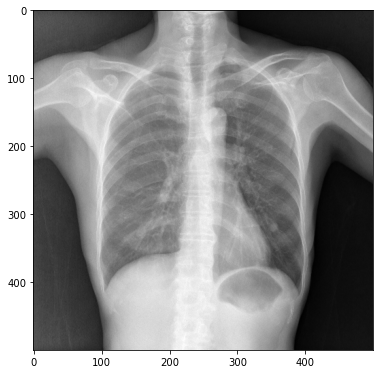

In [19]:
if VISUALIZATION_DICOM_ARRAY:
    dicom_paths = glob(f'{TRAIN_DATA_PATH}/*.dicom')
    imgs = [dicom2array(each_file) for each_file in dicom_paths[:DISPLAY_IMG_COUNT]]
    plot_imgs(imgs)

In [20]:
if VISUALIZATION_DICOM_ARRAY_MONOCHROME:
    dicom_paths = glob(f'{TRAIN_DATA_PATH}/*.dicom')
    imgs = [dicom2array(each_file, fix_monochrome=False) for each_file in dicom_paths[:DISPLAY_IMG_COUNT]]
    plot_imgs(imgs)

In [21]:
if PREPROCESSING_DICOM_ARRAY:
    for each_file in tqdm(os.listdir(TRAIN_DATA_PATH)):
        old_path = os.path.join(TRAIN_DATA_PATH, each_file)
        img = dicom2array(old_path)
        new_path = TRAIN_PREPROCESSING_DICOM_ARRAY_PATH
        cv2.imwrite(os.path.join(new_path, each_file).replace('.dicom', IMAGE_NAME_EXTENSION), img)
        
    for each_file in tqdm(os.listdir(TEST_DATA_PATH)):
        old_path = os.path.join(TEST_DATA_PATH, each_file)
        img = dicom2array(old_path)
        new_path = TEST_PREPROCESSING_DICOM_ARRAY_PATH
        cv2.imwrite(os.path.join(new_path, each_file).replace('.dicom', IMAGE_NAME_EXTENSION), img)

In [22]:
if PREPROCESSING_DICOM_ARRAY_MONOCHROME:
    for each_file in tqdm(os.listdir(TRAIN_DATA_PATH)):
        old_path = os.path.join(TRAIN_DATA_PATH, each_file)
        img = dicom2array(old_path)
        new_path = TRAIN_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH
        cv2.imwrite(os.path.join(new_path, each_file).replace('.dicom', IMAGE_NAME_EXTENSION), img)
        
    for each_file in tqdm(os.listdir(TEST_DATA_PATH)):
        old_path = os.path.join(TEST_DATA_PATH, each_file)
        img = dicom2array(old_path)
        new_path = TEST_PREPROCESSING_DICOM_ARRAY_MONOCHROME_PATH
        cv2.imwrite(os.path.join(new_path, each_file).replace('.dicom', IMAGE_NAME_EXTENSION), img)

[Go to Top](#0)